# Holiday Effect Strategy - Options Strategy

Implement put-selling overlay strategy around holiday events.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from options_strategy import OptionsStrategy
from data_acquisition import DataAcquisition
from signal_generator import SignalGenerator

plt.style.use('seaborn-v0_8-darkgrid')

## 1. Load Data and Generate Event Windows

In [2]:
# Load data
data_acq = DataAcquisition('config.yaml')
dataset = data_acq.fetch_full_dataset()

# Generate event windows
signal_gen = SignalGenerator('config.yaml')
signals, windows = signal_gen.generate_signal_series(dataset['amzn_prices'].index)

print(f"Total event windows: {len(windows)}")
print(f"Black Friday events: {len(windows[windows['event_type'] == 'black_friday'])}")
print(f"Prime Day events: {len(windows[windows['event_type'] == 'prime_day'])}")

# Use only 2012+ per research
recent_windows = windows[windows['year'] >= 2012]
print(f"\nRecent windows (2012+): {len(recent_windows)}")

Fetching AMZN data from 1998-01-01 to 2025-12-31...
Fetching SPY data from 1998-01-01 to 2025-12-31...
Fetching VIX data...
Total event windows: 39
Black Friday events: 28
Prime Day events: 11

Recent windows (2012+): 25


## 2. Simulate Put Selling Strategy

In [3]:
# Initialize options strategy
options_strat = OptionsStrategy('config.yaml')

# Simulate trades
trades = options_strat.simulate_options_trades(
    recent_windows,
    dataset['amzn_prices'],
    initial_capital=1000000
)

print("=== Options Trades ===")
print(trades[['entry_date', 'event_type', 'entry_price', 'exit_price', 
              'strike', 'premium_collected', 'pnl', 'outcome']].head(10))

=== Options Trades ===
  entry_date    event_type  entry_price  exit_price  strike  \
0 2012-11-08  black_friday    11.367500   11.994000      10   
1 2013-11-14  black_friday    18.370001   19.681000      15   
2 2014-11-13  black_friday    15.824000   16.931999      15   
3 2015-11-12  black_friday    33.279999   33.662998      30   
4 2015-06-30     prime_day    21.704500   23.059500      20   
5 2016-11-10  black_friday    37.118999   39.018501      35   
6 2016-06-27     prime_day    34.568001   37.410500      35   
7 2017-11-09  black_friday    56.456501   59.299999      55   
8 2017-06-26     prime_day    49.699001   49.706501      45   
9 2018-11-08  black_friday    87.745499   75.102997      85   

   premium_collected          pnl outcome  
0          43.000000    43.000000     win  
1          27.000000    27.000000     win  
2         291.662703   291.662703     win  
3          49.370592    49.370592     win  
4         115.239091   115.239091     win  
5         243.22815

## 3. Performance Metrics

In [4]:
# Calculate metrics
metrics = options_strat.calculate_metrics(trades)

print("=== Options Strategy Performance ===")
print(f"Total Trades:          {metrics['total_trades']}")
print(f"Winning Trades:        {metrics['winning_trades']}")
print(f"Win Rate:              {metrics['win_rate']*100:.1f}%")
print(f"Total Premium:         ${metrics['total_premium_collected']:,.2f}")
print(f"Total PnL:             ${metrics['total_pnl']:,.2f}")
print(f"Avg Premium/Trade:     ${metrics['avg_premium_per_trade']:,.2f}")
print(f"Avg PnL/Trade:         ${metrics['avg_pnl_per_trade']:,.2f}")
print(f"Final Portfolio Value: ${metrics['final_portfolio_value']:,.2f}")

# Calculate return
total_return = (metrics['final_portfolio_value'] - 1000000) / 1000000 * 100
print(f"Total Return:          {total_return:.2f}%")

=== Options Strategy Performance ===
Total Trades:          25
Winning Trades:        23
Win Rate:              92.0%
Total Premium:         $7,917.64
Total PnL:             $2,657.14
Avg Premium/Trade:     $316.71
Avg PnL/Trade:         $106.29
Final Portfolio Value: $1,002,657.14
Total Return:          0.27%


## 4. Trade Outcomes Visualization

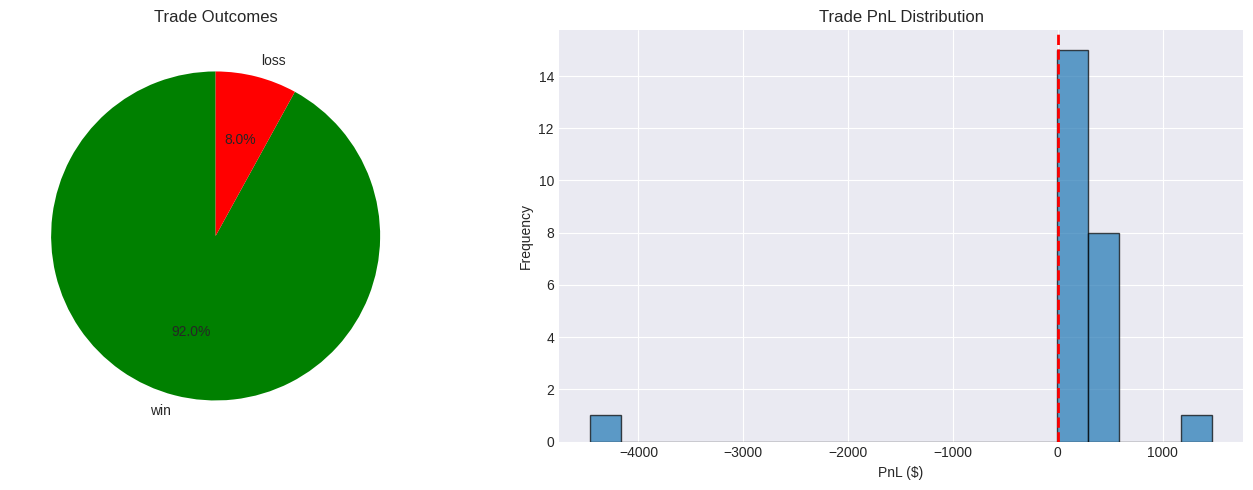

In [5]:
# Win/Loss distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Outcome counts
outcome_counts = trades['outcome'].value_counts()
axes[0].pie(outcome_counts, labels=outcome_counts.index, autopct='%1.1f%%',
            colors=['green', 'red'], startangle=90)
axes[0].set_title('Trade Outcomes')

# PnL distribution
axes[1].hist(trades['pnl'], bins=20, edgecolor='black', alpha=0.7)
axes[1].axvline(0, color='red', linestyle='--', linewidth=2)
axes[1].set_title('Trade PnL Distribution')
axes[1].set_xlabel('PnL ($)')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

## 5. Cumulative Performance

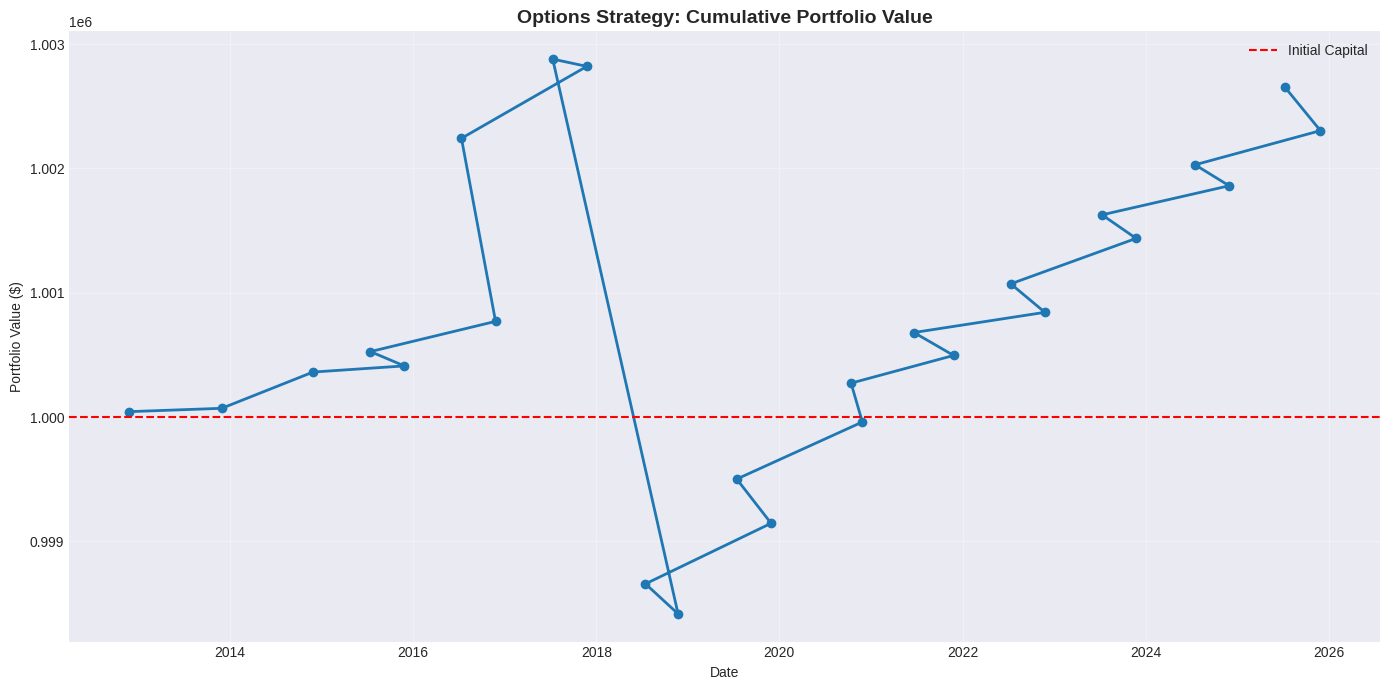

In [6]:
# Plot cumulative portfolio value
fig, ax = plt.subplots(figsize=(14, 7))
ax.plot(trades['exit_date'], trades['portfolio_value'], linewidth=2, marker='o')
ax.axhline(1000000, color='red', linestyle='--', label='Initial Capital')
ax.set_title('Options Strategy: Cumulative Portfolio Value', fontsize=14, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Portfolio Value ($)')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 6. Event Type Analysis

=== Performance by Event Type ===
                     pnl                    premium_collected   outcome
                    mean          sum count              mean  <lambda>
event_type                                                             
black_friday  -73.158023 -1024.212316    14        280.306377  0.928571
prime_day     334.668057  3681.348627    11        363.031649  0.909091


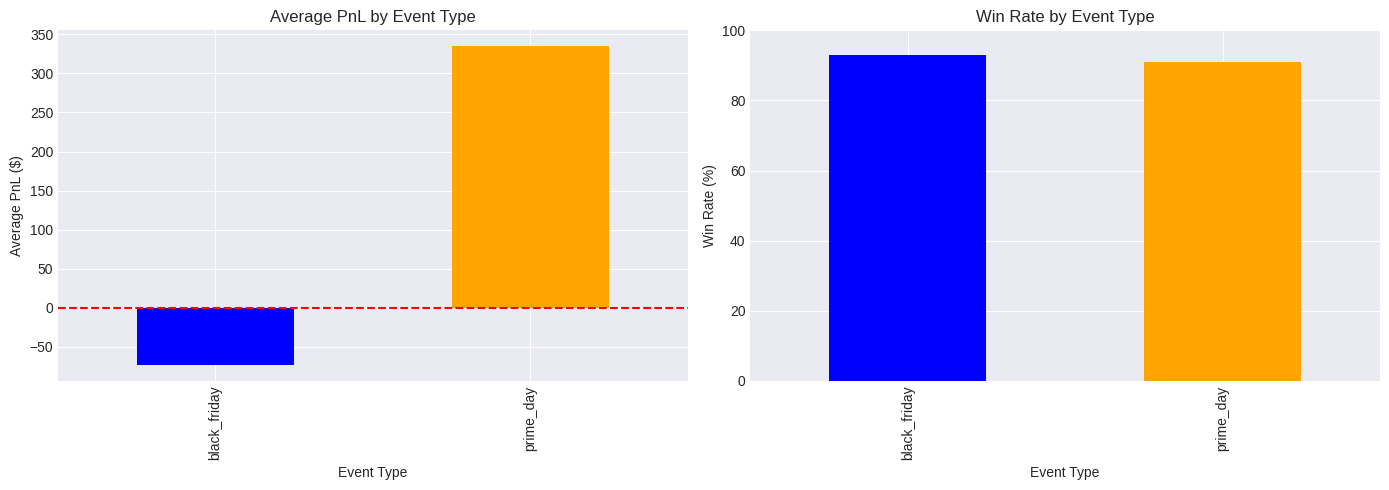

In [7]:
# Compare performance by event type
event_performance = trades.groupby('event_type').agg({
    'pnl': ['mean', 'sum', 'count'],
    'premium_collected': 'mean',
    'outcome': lambda x: (x == 'win').sum() / len(x)
})

print("=== Performance by Event Type ===")
print(event_performance)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Average PnL by event
event_pnl = trades.groupby('event_type')['pnl'].mean()
event_pnl.plot(kind='bar', ax=axes[0], color=['blue', 'orange'])
axes[0].set_title('Average PnL by Event Type')
axes[0].set_ylabel('Average PnL ($)')
axes[0].set_xlabel('Event Type')
axes[0].axhline(0, color='red', linestyle='--')

# Win rate by event
event_winrate = trades.groupby('event_type')['outcome'].apply(lambda x: (x == 'win').sum() / len(x) * 100)
event_winrate.plot(kind='bar', ax=axes[1], color=['blue', 'orange'])
axes[1].set_title('Win Rate by Event Type')
axes[1].set_ylabel('Win Rate (%)')
axes[1].set_xlabel('Event Type')
axes[1].set_ylim([0, 100])

plt.tight_layout()
plt.show()

## 7. Risk Analysis

In [8]:
# Calculate risk metrics
returns = trades['pnl'] / 1000000  # As fraction of initial capital

print("=== Risk Metrics ===")
print(f"Average Return per Trade: {returns.mean()*100:.4f}%")
print(f"Std Dev of Returns:       {returns.std()*100:.4f}%")
print(f"Sharpe Ratio (approx):    {returns.mean() / returns.std() if returns.std() > 0 else 0:.2f}")
print(f"Max Loss:                 ${trades['pnl'].min():,.2f}")
print(f"Max Gain:                 ${trades['pnl'].max():,.2f}")
print(f"Profit Factor:            {trades[trades['pnl'] > 0]['pnl'].sum() / abs(trades[trades['pnl'] < 0]['pnl'].sum()) if len(trades[trades['pnl'] < 0]) > 0 else float('inf'):.2f}")

=== Risk Metrics ===
Average Return per Trade: 0.0106%
Std Dev of Returns:       0.0993%
Sharpe Ratio (approx):    0.11
Max Loss:                 $-4,463.46
Max Gain:                 $1,472.72
Profit Factor:            1.60


## 8. Combined Strategy (Equity + Options)

In [9]:
# Simulate combined portfolio
# 95% SPY base + 5% options overlay

spy_allocation = 0.95
options_allocation = 0.05

# SPY buy-and-hold returns
spy_recent = dataset['spy_prices'].loc[recent_windows.iloc[0]['entry_date']:]
spy_returns = (spy_recent['Adj Close'].iloc[-1] - spy_recent['Adj Close'].iloc[0]) / spy_recent['Adj Close'].iloc[0]

# Options returns
options_returns = (metrics['final_portfolio_value'] - 1000000) / 1000000

# Combined returns
combined_return = spy_allocation * spy_returns + options_allocation * options_returns

print("=== Combined Strategy ===")
print(f"SPY Component (95%):      {spy_returns*100:.2f}%")
print(f"Options Component (5%):   {options_returns*100:.2f}%")
print(f"Combined Return:          {combined_return*100:.2f}%")
print(f"\nEnhancement from Options: {(combined_return - spy_returns)*100:.2f}%")

=== Combined Strategy ===
SPY Component (95%):      527.81%
Options Component (5%):   0.27%
Combined Return:          501.43%

Enhancement from Options: -26.38%
